# 02: Variational Autoencoder (VAE) for Anomaly Detection

### Introduction

This notebook is the core of the `CosmicLegacy` project. Here, we will build and train a deep learning model to "learn" what a normal patch of the Cosmic Microwave Background looks like. We will use a Variational Autoencoder (VAE), a type of generative model that is particularly well-suited for anomaly detection.

The principle is simple: we train the VAE to reconstruct "normal" CMB patches with very high accuracy. When we later show it a truly anomalous patch, it will fail to reconstruct it properly. The magnitude of this failure (the "reconstruction error") will be our anomaly score.

### Step 1: Environment Setup

As before, we begin by mounting our Google Drive to access our dataset and save our trained model. We then import the necessary libraries. The key library for this notebook is `TensorFlow`, a powerful open-source platform for machine learning.

In [31]:
# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Standard Library Imports ---
import os
import numpy as np
import matplotlib.pyplot as plt

# --- Deep Learning Imports ---
# TensorFlow is the core library we will use to build and train our model.
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

# --- Path Definitions ---
project_path = '/content/drive/My Drive/CosmicLegacy'
data_path = os.path.join(project_path, 'data')
model_path = os.path.join(project_path, 'models')
os.makedirs(model_path, exist_ok=True) # Create a directory for our saved models

print(f"Project path: {project_path}")
print(f"Data path: {data_path}")
print(f"Models will be saved to: {model_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project path: /content/drive/My Drive/CosmicLegacy
Data path: /content/drive/My Drive/CosmicLegacy/data
Models will be saved to: /content/drive/My Drive/CosmicLegacy/models


### Step 2: Load the Dataset

We will now load the patch dataset that we meticulously prepared and saved in the previous notebook. This file contains an array of clean, 32x32 pixel patches of the CMB temperature map.

In [32]:
# --- Load the patch dataset from the .npy file ---
# We construct the full path to the file saved in Notebook 01.
# Make sure the filename matches the one you saved.
dataset_filename = "cmb_temp_patches_masked_1000x32x32.npy"
dataset_filepath = os.path.join(data_path, dataset_filename)

try:
    print(f"Loading dataset from: {dataset_filepath}...")
    patches = np.load(dataset_filepath)
    print("Dataset loaded successfully.")
    print(f"Dataset shape: {patches.shape}")
    print(f"Data type: {patches.dtype}")
except FileNotFoundError:
    print(f"ERROR: Dataset file not found at {dataset_filepath}")
    print("Please ensure you have run Notebook 01 and the file was saved correctly.")

Loading dataset from: /content/drive/My Drive/CosmicLegacy/data/cmb_temp_patches_masked_1000x32x32.npy...
Dataset loaded successfully.
Dataset shape: (1000, 32, 32)
Data type: float64


### Step 3: Preprocess the Data

Neural networks generally perform best when their input data is scaled to a small, standard range, such as [0, 1] or [-1, 1]. This process is called **normalization**. It helps the model learn more efficiently and stably. We will scale our CMB temperature fluctuation values to the [0, 1] range.

In [33]:
if 'patches' in locals():
    # --- Reshape and Normalize the Data ---
    # First, we find the minimum and maximum temperature values in the entire dataset.
    min_val = np.min(patches)
    max_val = np.max(patches)
    print(f"Original data range: Min = {min_val:.6f}, Max = {max_val:.6f}")

    # Apply min-max scaling to transform the data to the [0, 1] range.
    # The formula is: X_scaled = (X - X_min) / (X_max - X_min)
    patches_normalized = (patches - min_val) / (max_val - min_val)

    # Keras expects an additional 'channel' dimension at the end of the image data.
    # For grayscale images like ours, this will be 1.
    # We reshape our data from (num_samples, height, width) to (num_samples, height, width, 1).
    patches_final = np.expand_dims(patches_normalized, axis=-1)

    print(f"\nNormalized data range: Min = {np.min(patches_final):.1f}, Max = {np.max(patches_final):.1f}")
    print(f"Final data shape for the model: {patches_final.shape}")

Original data range: Min = -0.000461, Max = 0.000484

Normalized data range: Min = 0.0, Max = 1.0
Final data shape for the model: (1000, 32, 32, 1)


### Step 4: Building the VAE Model (Final Corrected Version)

This version incorporates the final fix for the `ValueError` encountered during training. The error was caused by incorrectly wrapping the `MeanSquaredError` loss function, which already computes the final scalar loss value, inside redundant reduction operations. This has now been corrected.

In [34]:
# --- Hyperparameters ---
input_shape = (32, 32, 1)
latent_dim = 16

# --- Encoder and Decoder Architectures (no changes here) ---
# ... (код энкодера, сэмплера и декодера остаётся таким же, как в прошлый раз)
encoder_inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = models.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(4 * 4 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((4, 4, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = models.Model(latent_inputs, decoder_outputs, name="decoder")


# --- VAE Model with CORRECTED loss calculation ---
class VAE(models.Model):
    def __init__(self, encoder, decoder, kl_beta=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.kl_beta = kl_beta
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = Sampling()([z_mean, z_log_var])
            reconstruction = self.decoder(z)

            # --- CRITICAL FIX: Use the result of MSE directly ---
            # MeanSquaredError() already returns the final scalar loss for the batch.
            reconstruction_loss_fn = tf.keras.losses.MeanSquaredError()
            reconstruction_loss = reconstruction_loss_fn(data, reconstruction)

            # To make it comparable in scale to the old BCE loss and KL loss,
            # we can scale it by the number of pixels.
            reconstruction_loss *= input_shape[0] * input_shape[1]

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + self.kl_beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss": self.total_loss_tracker.result(), "reconstruction_loss": self.reconstruction_loss_tracker.result(), "kl_loss": self.kl_loss_tracker.result()}

# Instantiate the final VAE model.
vae = VAE(encoder, decoder, kl_beta=0.1)
print("\nFINAL VAE model created with corrected loss calculation.")


FINAL VAE model created with corrected loss calculation.


### Step 5: Compile and Train the Final Model

We will now compile and train our final, most powerful VAE. Compiling configures the model with an optimizer (`Adam` is a robust choice). The training process (`.fit`) will run for 50 epochs to give the deeper architecture sufficient time to learn and converge. After training, we will plot the loss curves on a logarithmic scale to clearly visualize the learning progress.


Starting FINAL model training...
Epoch 1/50
32/32 - 6s - 188ms/step - kl_loss: 0.0602 - loss: 13.4714 - reconstruction_loss: 13.4654
Epoch 2/50
32/32 - 3s - 103ms/step - kl_loss: 1.2518 - loss: 13.0157 - reconstruction_loss: 12.8906
Epoch 3/50
32/32 - 3s - 107ms/step - kl_loss: 4.2747 - loss: 10.3420 - reconstruction_loss: 9.9145
Epoch 4/50
32/32 - 4s - 130ms/step - kl_loss: 4.3566 - loss: 8.9511 - reconstruction_loss: 8.5155
Epoch 5/50
32/32 - 2s - 77ms/step - kl_loss: 4.9932 - loss: 7.9687 - reconstruction_loss: 7.4694
Epoch 6/50
32/32 - 3s - 82ms/step - kl_loss: 6.5800 - loss: 7.1158 - reconstruction_loss: 6.4578
Epoch 7/50
32/32 - 5s - 154ms/step - kl_loss: 6.8875 - loss: 6.6091 - reconstruction_loss: 5.9203
Epoch 8/50
32/32 - 2s - 77ms/step - kl_loss: 6.6981 - loss: 6.2782 - reconstruction_loss: 5.6084
Epoch 9/50
32/32 - 2s - 77ms/step - kl_loss: 6.7057 - loss: 6.0416 - reconstruction_loss: 5.3710
Epoch 10/50
32/32 - 3s - 83ms/step - kl_loss: 6.7718 - loss: 5.7305 - reconstructio

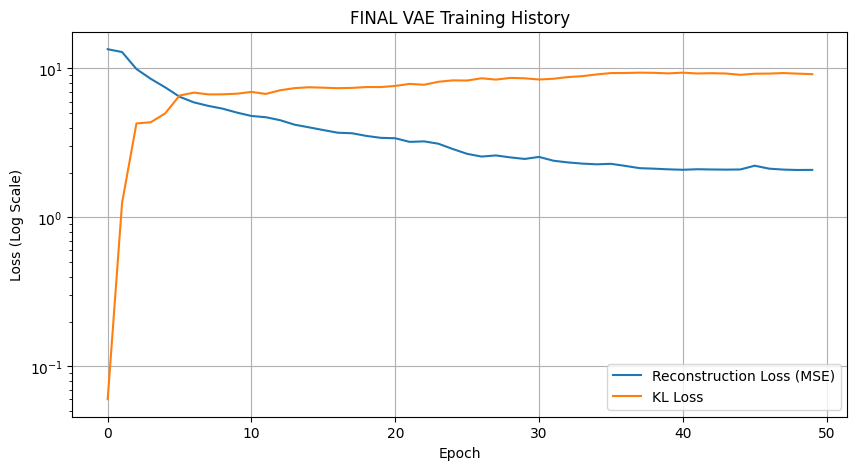

In [35]:
# --- Compile the Model ---
# We only need to provide an optimizer, as the loss calculation is handled
# inside the model's custom train_step method.
vae.compile(optimizer=tf.keras.optimizers.Adam())

# --- Train the Model ---
# We train for 50 epochs to allow the deeper model to learn the complex patterns.
print("\nStarting FINAL model training...")
history = vae.fit(patches_final, epochs=50, batch_size=32, verbose=2) # Using verbose=2 for cleaner logs
print("Model training complete.")

# --- Visualize Training History ---
# Plotting the loss curves is the best way to diagnose the training process.
# We hope to see a clear downward trend in the reconstruction loss, indicating
# that the model is getting better at its task.
print("\nPlotting training history...")
plt.figure(figsize=(10, 5))
# We plot reconstruction_loss, as it's the primary measure of performance for an autoencoder.
plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss (MSE)')
plt.plot(history.history['kl_loss'], label='KL Loss')
plt.title('FINAL VAE Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (Log Scale)')
plt.legend()
plt.grid(True)
# Use a logarithmic scale for the y-axis to better see changes in a loss that might be large.
plt.yscale('log')
plt.show()

### Step 6: Visual Evaluation of the Model

The loss curves show that the model has learned, but the ultimate test is to visually inspect its performance. We will take a few sample patches from our dataset, pass them through the trained VAE, and plot the original patches side-by-side with their reconstructions. A good model should produce reconstructions that are slightly blurry or simplified, but capture the essential shapes and structures of the original images.

Displaying original vs. reconstructed patches...


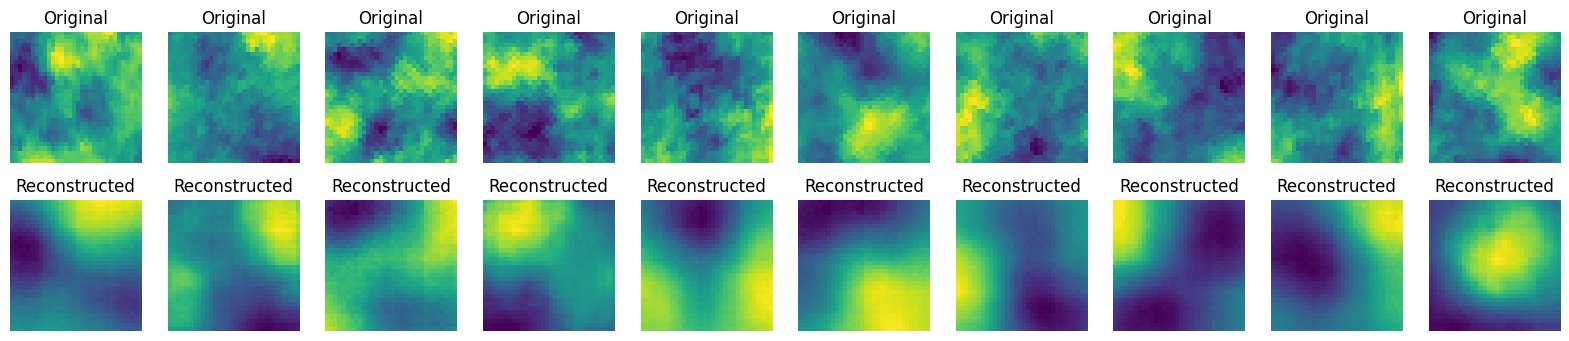

In [36]:
if 'vae' in locals() and 'patches_final' in locals():
    # --- Select a few random patches to test ---
    num_examples_to_show = 10
    test_dataset = tf.data.Dataset.from_tensor_slices(patches_final).batch(num_examples_to_show)
    original_patches = next(iter(test_dataset))

    # --- Run the patches through the VAE to get the reconstructions ---
    z_mean, z_log_var = vae.encoder.predict(original_patches, verbose=0)
    z = Sampling()([z_mean, z_log_var])
    reconstructed_patches = vae.decoder.predict(z, verbose=0)

    # --- Plot the results ---
    print("Displaying original vs. reconstructed patches...")
    plt.figure(figsize=(20, 4))
    for i in range(num_examples_to_show):
        # Plot original image
        ax = plt.subplot(2, num_examples_to_show, i + 1)
        # CRITICAL FIX: Convert the TensorFlow EagerTensor to a NumPy array using .numpy() before reshaping.
        plt.imshow(original_patches[i].numpy().reshape(32, 32), cmap='viridis')
        plt.title("Original")
        plt.axis("off")

        # Plot reconstructed image
        ax = plt.subplot(2, num_examples_to_show, i + 1 + num_examples_to_show)
        # model.predict() returns a NumPy array, so no .numpy() is needed here.
        plt.imshow(reconstructed_patches[i].reshape(32, 32), cmap='viridis')
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()
else:
    print("Model or dataset not found.")

### Step 7: Save the Trained Model

This is the final step of our notebook. We save the learned weights of our encoder and decoder networks. We use the `.weights.h5` extension, which is the standard format required by modern Keras versions for saving model weights. These files are the tangible output of our training process and will be loaded in the next notebook to perform the anomaly detection.

In [37]:
if 'vae' in locals():
    # --- Define file paths for the model weights with the correct extension ---
    # Keras 3 requires the '.weights.h5' extension for saving weights.
    encoder_weights_path = os.path.join(model_path, 'vae_encoder.weights.h5')
    decoder_weights_path = os.path.join(model_path, 'vae_decoder.weights.h5')

    # --- Save the weights ---
    vae.encoder.save_weights(encoder_weights_path)
    vae.decoder.save_weights(decoder_weights_path)

    print(f"Encoder weights saved to: {encoder_weights_path}")
    print(f"Decoder weights saved to: {decoder_weights_path}")
else:
    print("VAE model not found, cannot save weights.")

Encoder weights saved to: /content/drive/My Drive/CosmicLegacy/models/vae_encoder.weights.h5
Decoder weights saved to: /content/drive/My Drive/CosmicLegacy/models/vae_decoder.weights.h5
